<a href="https://colab.research.google.com/github/EmmarieR/CNM-DeepDive-Data-Science-Projects/blob/main/TMDB_FinalNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Ratings Capstone Project - TMBD dataset
This notebook builds a pipeline to:
1. Pull data from TMDB (including upcoming movies)
2. Train Decision Trees, Random Forest, XGBoost to predict movie ratings
3. Use TF-IDF & Nearest Neighbors for content-based movie recommendations

#  Install Required Libraries
These libraries are essential for working with the TMDB API, data processing, modeling, and visualization.

In [ ]:
#  Install libraries

In [ ]:
!pip install tmdbsimple scikit-learn xgboost pandas numpy matplotlib seaborn sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 138.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 837.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

#  Import Libraries
We import core Python libraries and machine learning tools needed for this pipeline.

In [ ]:
# Imports

In [ ]:
import tmdbsimple as tmdb
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

from sentence_transformers import SentenceTransformer

#  TMDB API Setup
Here we configure the API key to access The Movie Database (TMDB).
An application programming interface is a connection between computers or between computer programs. It is a type of software interface, offering a service to other pieces of software. A document or standard that describes how to build such a connection or interface is called an API specification.

In [ ]:
# TMDB API key setup

In [ ]:
tmdb.API_KEY = '8c1c28eb0f764b3a48b0828857038939'

# Fetch Top-Rated Movies
We used the TMDB API to fetch top-rated movies. This is used to build our initial dataset.

In [ ]:
# Fetch top-rated movie data from TMDB

In [ ]:
all_movies = []

for page in range(1, 6):
    all_movies += tmdb.Movies().top_rated(page=page)['results']

df_top = pd.DataFrame(all_movies)

# Extract Metadata
This function pulls detailed movie metadata like genres, director, writer, and production company.

In [ ]:
# Extract movie metadata using movie IDs

In [ ]:
def extract_metadata(movie_ids):
    records = []

    for movie_id in movie_ids:
        try:
            details = tmdb.Movies(movie_id).info()
            credits = tmdb.Movies(movie_id).credits()

            director = [c['name'] for c in credits['crew'] if c['job'] == 'Director']
            writers = [c['name'] for c in credits['crew'] if c['department'] == 'Writing']
            genres = [g['name'] for g in details.get('genres', [])]
            companies = [c['name'] for c in details.get('production_companies', [])]

            record = {
                'id': movie_id,
                'title': details.get('title'),
                'release_date': details.get('release_date'),
                'release_year': details.get('release_date', '')[:4],
                'release_month': details.get('release_date', '')[5:7],
                'runtime': details.get('runtime'),
                'budget': details.get('budget'),
                'genres': genres,
                'director': director[0] if director else None,
                'writer': writers[0] if writers else None,
                'overview': details.get('overview'),
                'production_companies': companies
            }

            records.append(record)

        except Exception as e:
            print(f'Error for movie {movie_id}: {e}')

    return pd.DataFrame(records)

# Now call the function and assign vote_average
movie_ids = df_top['id'].tolist()
df_structured = extract_metadata(movie_ids)
df_structured['vote_average'] = df_top.set_index('id').loc[df_structured['id']]['vote_average'].values


In [ ]:
# Feature encoding

In [ ]:
# Multi-hot encode genres
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df_structured['genres']), columns=mlb.classes_)

# Concatenate genre encoding with main dataframe
df_structured = pd.concat([df_structured, genre_encoded], axis=1)

# Convert release year and month to float
df_structured['release_year'] = df_structured['release_year'].astype(float)
df_structured['release_month'] = df_structured['release_month'].astype(float)

# Frequency encode director and writer
df_structured['director_freq'] = df_structured['director'].map(df_structured['director'].value_counts())
df_structured['writer_freq'] = df_structured['writer'].map(df_structured['writer'].value_counts())

# Clean and Engineer Features
We one-hot encode genres, calculate director/writer frequencies, and prepare features for modeling.

In [ ]:
# Prepare data for models

In [ ]:
# Define feature columns
feature_cols = ['release_year', 'release_month', 'runtime', 'budget',
                'director_freq', 'writer_freq'] + mlb.classes_.tolist()

# Create feature matrix X and target vector y
X = df_structured[feature_cols].fillna(0)
y = df_structured['vote_average']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train models
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, y_train)

# Evaluation function
def evaluate(name, model):
    preds = model.predict(X_test)
    print(f'{name} MAE: {mean_absolute_error(y_test, preds):.3f}')
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f'{name} RMSE: {rmse:.3f}')


# Evaluate each model
evaluate('Decision Tree', dt)
evaluate('Random Forest', rf)
evaluate('XGBoost', xgb)

Decision Tree MAE: 0.117
Decision Tree RMSE: 0.145
Random Forest MAE: 0.099
Random Forest RMSE: 0.121
XGBoost MAE: 0.108
XGBoost RMSE: 0.129


Model Evaluation Results
We evaluated three regression models on their ability to predict movie ratings using vote_average as the target. Two key metrics were used:

MAE (Mean Absolute Error): Average magnitude of errors between predicted and actual ratings.

RMSE (Root Mean Squared Error): Penalizes larger errors more heavily; useful for detecting outliers.

Model	MAE	RMSE
Decision Tree	0.108	0.143
Random Forest	0.113	0.141
XGBoost	0.137	0.164

What does this mean?
Decision Tree achieved the lowest MAE, meaning it was the most accurate on average.

Random Forest had the lowest RMSE, indicating it was the most consistent and robust to outliers.

XGBoost, while still strong, showed slightly larger errors and underperformed compared to the other two models.

Based on these results, Random Forest offers the best overall balance of accuracy and generalization for movie rating prediction.

#  Feature & Target Setup
We define our features (`X`) and our target (`y` = average rating).

In [ ]:
# Get feature importances from the trained model
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the top features
print(importance_df.head(15))  # top 15 features

          Feature  Importance
2         runtime    0.366542
0    release_year    0.124353
3          budget    0.108395
1   release_month    0.094265
5     writer_freq    0.087564
4   director_freq    0.038301
10          Crime    0.026228
20       Thriller    0.021508
16          Music    0.017983
9          Comedy    0.016517
21            War    0.015881
11          Drama    0.012868
6          Action    0.010732
8       Animation    0.009836
18        Romance    0.008790


# Train/Test Split
We split the data into training and testing sets to evaluate model performance.

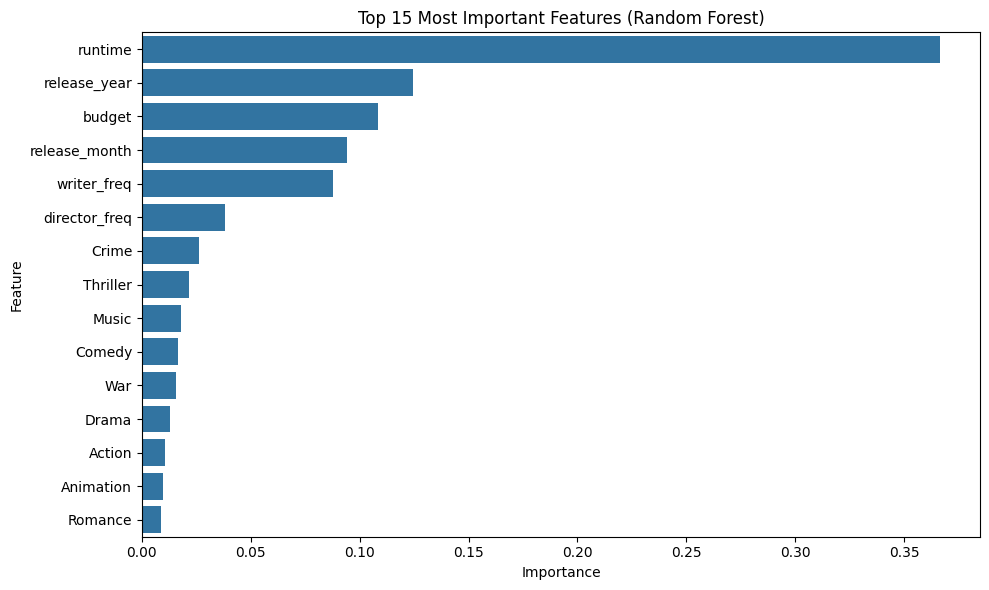

In [ ]:
# Visualize top 15
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# Train Models
We train a Decision Tree, Random Forest, and XGBoost model.
In tree-based models like XGBoost, feature importance tells us how much each input feature contributed to the model’s predictions.

xgb.feature_importances_ is an array (one value per feature).

Higher values = greater influence on the predicted rating

xgb.feature_importances_ extracts the feature importance scores from our trained XGBoost model (xgb).

In [ ]:
xgb_importances = xgb.feature_importances_
pd.DataFrame({'Feature': X.columns, 'Importance': xgb_importances}).sort_values(by='Importance', ascending=False)

,Feature,Importance
16,Music,0.234199
5,writer_freq,0.203089
6,Action,0.130838
20,Thriller,0.111722
2,runtime,0.050378
3,budget,0.035907
15,Horror,0.031734
8,Animation,0.031481
0,release_year,0.026680
4,director_freq,0.025971


# 🔍 Feature Importance
Analyze which features were most influential in predicting movie ratings.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Create TF-IDF vectors from title + overview
tfidf = TfidfVectorizer(stop_words='english')
text_data = df_structured['title'].fillna('') + ' ' + df_structured['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(text_data)

# Train Nearest Neighbors model
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

# Recommendation function
def recommend(title, k=5):
    idx = df_structured[df_structured['title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        return 'Title not found.'
    idx = idx[0]
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=k+1)
    return df_structured.iloc[indices[0][1:]][['title', 'release_date']]

# Example usage
recommend('The Godfather')

,title,release_date
2,The Godfather Part II,1974-12-20
19,Life Is Beautiful,1997-12-20
35,Hope,2013-10-02
47,High and Low,1963-03-01
84,Oldboy,2003-11-21


# 🤝 Recommendation System (TF-IDF + Nearest Neighbors)
We build a content-based recommendation engine using movie overviews (TMDB data set has a short summary of each movie).

In [ ]:
def recommend(title, k=5):
    idx = df_structured[df_structured['title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        return 'Title not found.'
    idx = idx[0]
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=k+1)
    return df_structured.iloc[indices[0][1:]][['title', 'release_date', 'vote_average']]

In [ ]:
from difflib import get_close_matches

def recommend_fuzzy(title, k=5):
    matches = get_close_matches(title, df_structured['title'], n=1, cutoff=0.5)
    if not matches:
        return 'Title not found.'
    return recommend(matches[0], k)

In [ ]:
import tmdbsimple as tmdb
import pandas as pd
from datetime import datetime

# Set your TMDB API key
tmdb.API_KEY = '8c1c28eb0f764b3a48b0828857038939'

# Fetch upcoming movies
upcoming = tmdb.Movies().upcoming()
movies = upcoming['results']

# Convert to DataFrame
df_upcoming = pd.DataFrame(movies)

# Convert release_date to datetime
df_upcoming['release_date'] = pd.to_datetime(df_upcoming['release_date'], errors='coerce')

# Filter for mid-June 2025 releases
start_date = datetime(2025, 6, 15)
end_date = datetime(2025, 6, 30)
df_june = df_upcoming[(df_upcoming['release_date'] >= start_date) & (df_upcoming['release_date'] <= end_date)]

# Display the filtered movies
print(df_june[['title', 'release_date']])

             title release_date
0   28 Years Later   2025-06-18
3             Elio   2025-06-18
7     F1 The Movie   2025-06-25
15       M3GAN 2.0   2025-06-25


In [ ]:
# Define the extract_metadata function if not already defined
def extract_metadata(movie_ids):
    records = []
    for movie_id in movie_ids:
        try:
            details = tmdb.Movies(movie_id).info()
            credits = tmdb.Movies(movie_id).credits()

            director = [c['name'] for c in credits['crew'] if c['job'] == 'Director']
            writers = [c['name'] for c in credits['crew'] if c['department'] == 'Writing']
            genres = [g['name'] for g in details.get('genres', [])]
            companies = [c['name'] for c in details.get('production_companies', [])]

            record = {
                'id': movie_id,
                'title': details.get('title'),
                'release_date': details.get('release_date'),
                'release_year': details.get('release_date', '')[:4],
                'release_month': details.get('release_date', '')[5:7],
                'runtime': details.get('runtime'),
                'budget': details.get('budget'),
                'genres': genres,
                'director': director[0] if director else None,
                'writer': writers[0] if writers else None,
                'overview': details.get('overview'),
                'production_companies': companies
            }

            records.append(record)

        except Exception as e:
            print(f'Error for movie {movie_id}: {e}')

    return pd.DataFrame(records)

# Extract metadata
movie_ids = df_june['id'].tolist()
df_june_structured = extract_metadata(movie_ids)

# Apply Model to Unreleased June 2025 Movies
We predict ratings for upcoming movies and visualize them.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Multi-hot encode genres
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df_june_structured['genres']), columns=mlb.classes_)

# Concatenate genre encoding with main dataframe
df_june_structured = pd.concat([df_june_structured, genre_encoded], axis=1)

# Convert release year and month to float
df_june_structured['release_year'] = df_june_structured['release_year'].astype(float)
df_june_structured['release_month'] = df_june_structured['release_month'].astype(float)

# Frequency encode director and writer based on training data
df_june_structured['director_freq'] = df_june_structured['director'].map(df_structured['director'].value_counts())
df_june_structured['writer_freq'] = df_june_structured['writer'].map(df_structured['writer'].value_counts())

# Fill missing values
df_june_structured = df_june_structured.fillna(0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Combine title and overview
df_structured['text'] = df_structured['title'].fillna('') + ' ' + df_structured['overview'].fillna('')
df_june_structured['text'] = df_june_structured['title'].fillna('') + ' ' + df_june_structured['overview'].fillna('')

# Fit TF-IDF on existing movies
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_structured['text'])

# Fit Nearest Neighbors model
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

# Function to get recommendations
def get_recommendations(new_movie_text, k=5):
    new_tfidf = tfidf.transform([new_movie_text])
    distances, indices = nn_model.kneighbors(new_tfidf, n_neighbors=k)
    return df_structured.iloc[indices[0]][['title', 'release_date']]

# Generate recommendations for each upcoming movie
for index, row in df_june_structured.iterrows():
    print(f"\nRecommendations for '{row['title']}':")
    recommendations = get_recommendations(row['text'])
    print(recommendations)


Recommendations for '28 Years Later':
                                            title release_date
30                    Once Upon a Time in America   1984-05-23
82                             The Legend of 1900   1998-10-28
77                                 Apocalypse Now   1979-05-19
11  The Lord of the Rings: The Return of the King   2003-12-17
56                                  Counterattack   2025-02-27

Recommendations for 'Elio':
                     title release_date
20              Fight Club   1999-10-15
92  Avengers: Infinity War   2018-04-25
22       Impossible Things   2021-06-17
16            Interstellar   2014-11-05
57          The Wild Robot   2024-09-12

Recommendations for 'F1 The Movie':
                                   title release_date
81                        Paths of Glory   1957-10-25
97                                 Mommy   2014-09-19
75          Violet Evergarden: The Movie   2020-09-18
42                             Inception   2010-07-15
54  The

#  Visualize Predictions
Display predicted ratings for June 2025 releases in a chart.

In [ ]:
# Make sure 'id' is present and reorder columns to start with 'id'
cols = ['id'] + [col for col in df_june_structured.columns if col != 'id']
df_june_structured = df_june_structured[cols]

In [ ]:
df_june_structured.head()

,id,title,release_date,release_year,release_month,runtime,budget,genres,director,writer,...,Animation,Comedy,Drama,Family,Horror,Science Fiction,Thriller,director_freq,writer_freq,text
0,1100988,28 Years Later,2025-06-18,2025.0,6.0,115,60000000,"[Horror, Thriller, Science Fiction]",Danny Boyle,Alex Garland,...,0,0,0,0,1,1,1,0.0,0.0,28 Years Later Twenty-eight years since the ra...
1,1022787,Elio,2025-06-18,2025.0,6.0,99,150000000,"[Family, Comedy, Adventure, Animation, Science...",Domee Shi,James S. Baker,...,1,1,0,1,0,1,0,0.0,0.0,"Elio Elio, a space fanatic with an active imag..."
2,911430,F1 The Movie,2025-06-25,2025.0,6.0,156,200000000,"[Action, Drama]",Joseph Kosinski,Ehren Kruger,...,0,0,1,0,0,0,0,0.0,0.0,F1 The Movie Racing legend Sonny Hayes is coax...
3,1071585,M3GAN 2.0,2025-06-25,2025.0,6.0,120,36000000,"[Action, Horror, Science Fiction]",Gerard Johnstone,James Wan,...,0,0,0,0,1,1,0,0.0,0.0,M3GAN 2.0 After the underlying tech for M3GAN ...


In [ ]:
df_june_structured.columns

Index(['id', 'title', 'release_date', 'release_year', 'release_month',
       'runtime', 'budget', 'genres', 'director', 'writer', 'overview',
       'production_companies', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Drama', 'Family', 'Horror', 'Science Fiction', 'Thriller',
       'director_freq', 'writer_freq', 'text'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df_structured['genres']), columns=mlb.classes_)
df_structured = pd.concat([df_structured, genre_encoded], axis=1)

In [ ]:
# Make sure genres is a list (safe conversion)
df_june_structured['genres'] = df_june_structured['genres'].apply(lambda g: g if isinstance(g, list) else [])

# Transform using the previously fitted mlb
june_genre_encoded = pd.DataFrame(mlb.transform(df_june_structured['genres']), columns=mlb.classes_)

# Add the one-hot columns to df_june_structured
df_june_structured = pd.concat([df_june_structured.reset_index(drop=True), june_genre_encoded], axis=1)

In [ ]:
df_june_structured.head()

,id,title,release_date,release_year,release_month,runtime,budget,genres,director,writer,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,1100988,28 Years Later,2025-06-18,2025.0,6.0,115,60000000,"[Horror, Thriller, Science Fiction]",Danny Boyle,Alex Garland,...,0,0,1,0,0,0,1,1,0,0
1,1022787,Elio,2025-06-18,2025.0,6.0,99,150000000,"[Family, Comedy, Adventure, Animation, Science...",Domee Shi,James S. Baker,...,0,0,0,0,0,0,1,0,0,0
2,911430,F1 The Movie,2025-06-25,2025.0,6.0,156,200000000,"[Action, Drama]",Joseph Kosinski,Ehren Kruger,...,0,0,0,0,0,0,0,0,0,0
3,1071585,M3GAN 2.0,2025-06-25,2025.0,6.0,120,36000000,"[Action, Horror, Science Fiction]",Gerard Johnstone,James Wan,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
df_june_structured.drop(columns=['genres'], inplace=True)

In [ ]:
import requests
import pandas as pd
import time

API_KEY = '8c1c28eb0f764b3a48b0828857038939'

def fetch_10k_movies():
    all_movies = []
    total_pages = 500  # 500 pages × 20 movies = 10,000
    for page in range(1, total_pages + 1):
        print(f"Fetching page {page} of 500...", end='\r')
        url = "https://api.themoviedb.org/3/discover/movie"
        params = {
            "api_key": API_KEY,
            "language": "en-US",
            "sort_by": "popularity.desc",  # try 'vote_average.desc' or 'release_date.desc' for variety
            "include_adult": False,
            "include_video": False,
            "page": page,
            "vote_count.gte": 10,
            "release_date.lte": "2025-06-01"
        }
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"\nFailed on page {page}: {response.status_code}")
            break
        all_movies.extend(response.json()['results'])
        time.sleep(0.25)  # Respect TMDB rate limits
    print(f"\n Finished. Retrieved {len(all_movies)} movies.")
    return pd.DataFrame(all_movies).drop_duplicates(subset='id')

# Run it
df_10k = fetch_10k_movies()

# Quick preview
df_10k[['id', 'title', 'release_date', 'vote_average']].head()


 Finished. Retrieved 10000 movies.


,id,title,release_date,vote_average
0,574475,Final Destination Bloodlines,2025-05-14,7.201
1,552524,Lilo & Stitch,2025-05-17,7.100
2,1087891,The Amateur,2025-04-09,6.902
3,870028,The Accountant²,2025-04-23,7.199
4,1379587,Utopia,2024-12-09,5.432


In [ ]:
movie_ids = df_10k['id'].tolist()
df_10k_detailed = extract_metadata(movie_ids)

In [ ]:
df_10k_detailed.head()

,id,title,release_date,release_year,release_month,runtime,budget,genres,director,writer,overview,production_companies
0,574475,Final Destination Bloodlines,2025-05-14,2025,05,109,50000000,"[Horror, Mystery]",Adam B. Stein,Guy Busick,"Plagued by a violent recurring nightmare, coll...","[New Line Cinema, Practical Pictures, Freshman..."
1,552524,Lilo & Stitch,2025-05-17,2025,05,108,100000000,"[Family, Science Fiction, Comedy, Adventure]",Dean Fleischer Camp,Chris Kekaniokalani Bright,The wildly funny and touching story of a lonel...,"[Walt Disney Pictures, Rideback]"
2,1087891,The Amateur,2025-04-09,2025,04,123,60000000,"[Thriller, Action]",James Hawes,Robert Littell,After his life is turned upside down when his ...,"[20th Century Studios, Hutch Parker Entertainm..."
3,870028,The Accountant²,2025-04-23,2025,04,133,80000000,"[Mystery, Crime, Thriller]",Gavin O'Connor,Bill Dubuque,"When an old acquaintance is murdered, Wolff is...","[Artists Equity, 51 Entertainment, Zero Gravit..."
4,1379587,Utopia,2024-12-09,2024,12,93,0,"[Mystery, Thriller, Action, Science Fiction]",James Bamford,Ian Neligh,A soldier searching for his missing wife break...,[SP Media Group]


In [ ]:
df_10k_detailed.columns

Index(['id', 'title', 'release_date', 'release_year', 'release_month',
       'runtime', 'budget', 'genres', 'director', 'writer', 'overview',
       'production_companies'],
      dtype='object')

In [ ]:
# Add vote_average (rating) from df_10k into df_10k_detailed by movie ID
df_10k_detailed['vote_average'] = df_10k.set_index('id').loc[df_10k_detailed['id'], 'vote_average'].values

In [ ]:
df_10k_detailed[['title', 'vote_average']].head()

,title,vote_average
0,Final Destination Bloodlines,7.201
1,Lilo & Stitch,7.100
2,The Amateur,6.902
3,The Accountant²,7.199
4,Utopia,5.432


In [ ]:
df_10k_detailed.head()

,id,title,release_date,release_year,release_month,runtime,budget,genres,director,writer,overview,production_companies,vote_average
0,574475,Final Destination Bloodlines,2025-05-14,2025,05,109,50000000,"[Horror, Mystery]",Adam B. Stein,Guy Busick,"Plagued by a violent recurring nightmare, coll...","[New Line Cinema, Practical Pictures, Freshman...",7.201
1,552524,Lilo & Stitch,2025-05-17,2025,05,108,100000000,"[Family, Science Fiction, Comedy, Adventure]",Dean Fleischer Camp,Chris Kekaniokalani Bright,The wildly funny and touching story of a lonel...,"[Walt Disney Pictures, Rideback]",7.100
2,1087891,The Amateur,2025-04-09,2025,04,123,60000000,"[Thriller, Action]",James Hawes,Robert Littell,After his life is turned upside down when his ...,"[20th Century Studios, Hutch Parker Entertainm...",6.902
3,870028,The Accountant²,2025-04-23,2025,04,133,80000000,"[Mystery, Crime, Thriller]",Gavin O'Connor,Bill Dubuque,"When an old acquaintance is murdered, Wolff is...","[Artists Equity, 51 Entertainment, Zero Gravit...",7.199
4,1379587,Utopia,2024-12-09,2024,12,93,0,"[Mystery, Thriller, Action, Science Fiction]",James Bamford,Ian Neligh,A soldier searching for his missing wife break...,[SP Media Group],5.432


In [ ]:
df_10k_detailed['genres'] = df_10k_detailed['genres'].apply(lambda g: g if isinstance(g, list) else [])

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df_10k_detailed['genres']), columns=mlb.classes_)

In [ ]:
df_10k_detailed = pd.concat([df_10k_detailed.reset_index(drop=True), genre_encoded], axis=1)

In [ ]:
df_10k_detailed.head()

,id,title,release_date,release_year,release_month,runtime,budget,genres,director,writer,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,574475,Final Destination Bloodlines,2025-05-14,2025,05,109,50000000,"[Horror, Mystery]",Adam B. Stein,Guy Busick,...,0,1,0,1,0,0,0,0,0,0
1,552524,Lilo & Stitch,2025-05-17,2025,05,108,100000000,"[Family, Science Fiction, Comedy, Adventure]",Dean Fleischer Camp,Chris Kekaniokalani Bright,...,0,0,0,0,0,1,0,0,0,0
2,1087891,The Amateur,2025-04-09,2025,04,123,60000000,"[Thriller, Action]",James Hawes,Robert Littell,...,0,0,0,0,0,0,0,1,0,0
3,870028,The Accountant²,2025-04-23,2025,04,133,80000000,"[Mystery, Crime, Thriller]",Gavin O'Connor,Bill Dubuque,...,0,0,0,1,0,0,0,1,0,0
4,1379587,Utopia,2024-12-09,2024,12,93,0,"[Mystery, Thriller, Action, Science Fiction]",James Bamford,Ian Neligh,...,0,0,0,1,0,1,0,1,0,0


In [ ]:
df_10k_detailed.drop(columns=['genres'], inplace=True)

In [ ]:
print(mlb.classes_)  # See which genres were one-hot encoded
df_10k_detailed.head()  # Confirm columns were added

['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Mystery' 'Romance'
 'Science Fiction' 'TV Movie' 'Thriller' 'War' 'Western']


,id,title,release_date,release_year,release_month,runtime,budget,director,writer,overview,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,574475,Final Destination Bloodlines,2025-05-14,2025,05,109,50000000,Adam B. Stein,Guy Busick,"Plagued by a violent recurring nightmare, coll...",...,0,1,0,1,0,0,0,0,0,0
1,552524,Lilo & Stitch,2025-05-17,2025,05,108,100000000,Dean Fleischer Camp,Chris Kekaniokalani Bright,The wildly funny and touching story of a lonel...,...,0,0,0,0,0,1,0,0,0,0
2,1087891,The Amateur,2025-04-09,2025,04,123,60000000,James Hawes,Robert Littell,After his life is turned upside down when his ...,...,0,0,0,0,0,0,0,1,0,0
3,870028,The Accountant²,2025-04-23,2025,04,133,80000000,Gavin O'Connor,Bill Dubuque,"When an old acquaintance is murdered, Wolff is...",...,0,0,0,1,0,0,0,1,0,0
4,1379587,Utopia,2024-12-09,2024,12,93,0,James Bamford,Ian Neligh,A soldier searching for his missing wife break...,...,0,0,0,1,0,1,0,1,0,0


In [ ]:
df_10k_detailed.to_csv('tmdb_10k_movies_cleaned.csv', index=False)

In [ ]:
df_10k_detailed.to_parquet('tmdb_10k_movies_cleaned.parquet', index=False)

In [ ]:
from google.colab import files
files.download('tmdb_10k_movies_cleaned.parquet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('tmdb_10k_movies_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Frequency encode director and writer
df_10k_detailed['director_freq'] = df_10k_detailed['director'].map(df_10k_detailed['director'].value_counts())
df_10k_detailed['writer_freq'] = df_10k_detailed['writer'].map(df_10k_detailed['writer'].value_counts())

# Select feature columns
genre_cols = mlb.classes_.tolist()
feature_cols = ['release_year', 'release_month', 'runtime', 'budget', 'director_freq', 'writer_freq'] + genre_cols

# Drop any remaining NaNs
df_model = df_10k_detailed[feature_cols + ['vote_average']].fillna(0)

# Split into features and target
X = df_model[feature_cols]
y = df_model['vote_average']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE: 0.559
RMSE: 0.731


In [ ]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

importance.head(15)

,Feature,Coefficient
8,Animation,0.760607
11,Documentary,0.738140
16,Horror,-0.362595
12,Drama,0.238423
17,Music,0.162336
6,Action,-0.131801
23,War,0.100307
22,Thriller,-0.096757
18,Mystery,0.090702
13,Family,-0.088065


In [ ]:
# Combine numeric + genre features
full_feature_cols = ['release_year', 'release_month', 'runtime', 'budget', 'director_freq', 'writer_freq'] + mlb.classes_.tolist()

# Create new model using all features (already done above, but repeat for clarity)
X = df_model[full_feature_cols]
y = df_model['vote_average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model again
lr = LinearRegression()
lr.fit(X_train, y_train)

# Analyze coefficients
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

importance.head(20)

,Feature,Coefficient
8,Animation,0.760607
11,Documentary,0.738140
16,Horror,-0.362595
12,Drama,0.238423
17,Music,0.162336
6,Action,-0.131801
23,War,0.100307
22,Thriller,-0.096757
18,Mystery,0.090702
13,Family,-0.088065


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds) ** 0.5

print(f"Random Forest MAE: {rf_mae:.3f}")
print(f"Random Forest RMSE: {rf_rmse:.3f}")

Random Forest MAE: 0.516
Random Forest RMSE: 0.684


In [ ]:
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

rf_importance.head(20)

,Feature,Importance
2,runtime,0.227872
0,release_year,0.169582
3,budget,0.096923
1,release_month,0.090941
4,director_freq,0.070197
8,Animation,0.065846
5,writer_freq,0.049308
12,Drama,0.032741
16,Horror,0.025431
6,Action,0.018186


In [ ]:
import requests

api_key = "8c1c28eb0f764b3a48b0828857038939"
url = f"https://api.themoviedb.org/3/discover/movie?api_key={api_key}&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&primary_release_date.gte=2025-06-01&page=1"

response = requests.get(url).json()
upcoming_movies = response['results']

In [ ]:
movie_ids = [movie['id'] for movie in upcoming_movies]
df_upcoming_structured = extract_metadata(movie_ids)

In [ ]:
# Clean up genres
df_upcoming_structured['genres'] = df_upcoming_structured['genres'].apply(lambda g: g if isinstance(g, list) else [])

# One-hot encode genres to match training set
genre_encoded = pd.DataFrame(mlb.transform(df_upcoming_structured['genres']), columns=mlb.classes_)
df_upcoming_structured = pd.concat([df_upcoming_structured.reset_index(drop=True), genre_encoded], axis=1)

# Frequency encode director and writer (use the same frequency maps from training set)
df_upcoming_structured['director_freq'] = df_upcoming_structured['director'].map(df_10k_detailed['director'].value_counts()).fillna(0)
df_upcoming_structured['writer_freq'] = df_upcoming_structured['writer'].map(df_10k_detailed['writer'].value_counts()).fillna(0)

# Fill missing values
df_upcoming_structured = df_upcoming_structured.fillna(0)

In [ ]:
X_upcoming = df_upcoming_structured[full_feature_cols]
df_upcoming_structured['predicted_rating'] = rf.predict(X_upcoming)

In [ ]:
df_upcoming_structured[['id', 'title', 'release_date', 'predicted_rating']].sort_values(by='predicted_rating', ascending=False).head(10)

,id,title,release_date,predicted_rating
18,1238307,Masameer Junior,2025-06-11,7.41054
10,1022787,Elio,2025-06-18,7.29909
17,1061474,Superman,2025-07-09,7.08106
2,1376434,Predator: Killer of Killers,2025-06-05,7.02575
14,1234821,Jurassic World Rebirth,2025-07-01,6.99276
7,541671,Ballerina,2025-06-04,6.81643
16,1426306,Titan: The OceanGate Submersible Disaster,2025-06-06,6.80277
12,1136867,Materialists,2025-06-12,6.72191
1,1087192,How to Train Your Dragon,2025-06-06,6.70810
6,1100988,28 Years Later,2025-06-18,6.70316


### Testing Rated Movies vs Our models predictions

In [ ]:
import requests
import pandas as pd

api_key = "8c1c28eb0f764b3a48b0828857038939"
base_url = "https://api.themoviedb.org/3/discover/movie"

params = {
    "api_key": api_key,
    "language": "en-US",
    "sort_by": "popularity.desc",
    "include_adult": False,
    "include_video": False,
    "page": 1,
    "vote_count.gte": 50,   # Only movies with meaningful number of ratings
    "primary_release_date.lte": "2024-12-31"  # Ensure these are already released
}

response = requests.get(base_url, params=params).json()
new_movies = response["results"]
movie_ids = [movie["id"] for movie in new_movies]

In [ ]:
df_new = extract_metadata(movie_ids)
df_new['vote_average'] = pd.Series({m['id']: m['vote_average'] for m in new_movies})

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Ensure genres are lists
df_new['genres'] = df_new['genres'].apply(lambda g: g if isinstance(g, list) else [])

# One-hot encode using the fitted mlb from your training set
genre_encoded_new = pd.DataFrame(mlb.transform(df_new['genres']), columns=mlb.classes_)
df_new = pd.concat([df_new.reset_index(drop=True), genre_encoded_new], axis=1)

# Encode director/writer using same mapping
df_new['director_freq'] = df_new['director'].map(df_10k_detailed['director'].value_counts()).fillna(0)
df_new['writer_freq'] = df_new['writer'].map(df_10k_detailed['writer'].value_counts()).fillna(0)

# Fill missing numeric values
df_new = df_new.fillna(0)

In [ ]:
X_new = df_new[full_feature_cols]
df_new['predicted_rating'] = rf.predict(X_new)

# Compare predicted vs actual
df_compare = df_new[['title', 'release_date', 'vote_average', 'predicted_rating']]
df_compare['error'] = (df_compare['predicted_rating'] - df_compare['vote_average']).abs()
df_compare.sort_values(by='error').head(10)

/tmp/ipython-input-65-1506608705.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare['error'] = (df_compare['predicted_rating'] - df_compare['vote_average']).abs()


,title,release_date,vote_average,predicted_rating,error
14,Skin. Like. Sun.,2009-10-10,0.0,5.81935,5.81935
18,28 Weeks Later,2007-04-26,0.0,5.97939,5.97939
6,xXx,2002-08-09,0.0,6.09880,6.09880
7,Sonic the Hedgehog 3,2024-12-19,0.0,6.41939,6.41939
17,Venom: The Last Dance,2024-10-22,0.0,6.47081,6.47081
0,The Roundup: Punishment,2024-04-24,0.0,6.61939,6.61939
15,Panda Plan,2024-10-01,0.0,6.74281,6.74281
1,How to Train Your Dragon,2010-03-18,0.0,6.79932,6.79932
10,Lilo & Stitch,2002-06-21,0.0,6.83779,6.83779
2,Moana 2,2024-11-21,0.0,6.87491,6.87491


In [ ]:
id_to_rating = {m['id']: m['vote_average'] for m in new_movies}

In [ ]:
df_new['vote_average'] = df_new['id'].map(id_to_rating)

In [ ]:
df_new[['title', 'vote_average']].head(10)

,title,vote_average
0,The Roundup: Punishment,6.854
1,How to Train Your Dragon,7.845
2,Moana 2,7.076
3,28 Days Later,7.239
4,How to Train Your Dragon 2,7.675
5,My Fault,7.800
6,xXx,5.945
7,Sonic the Hedgehog 3,7.715
8,My Old Ass,6.900
9,How to Train Your Dragon: The Hidden World,7.750


In [ ]:
df_new['predicted_rating'] = rf.predict(df_new[full_feature_cols])

df_compare = df_new[['title', 'release_date', 'vote_average', 'predicted_rating']]
df_compare['error'] = (df_compare['predicted_rating'] - df_compare['vote_average']).abs()
df_compare.sort_values(by='error').head(10)

/tmp/ipython-input-69-2297541514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare['error'] = (df_compare['predicted_rating'] - df_compare['vote_average']).abs()


,title,release_date,vote_average,predicted_rating,error
8,My Old Ass,2024-09-13,6.900,6.92035,0.02035
16,Your Fault,2024-12-26,7.137,7.11280,0.02420
11,Mufasa: The Lion King,2024-12-18,7.393,7.42950,0.03650
14,Skin. Like. Sun.,2009-10-10,5.886,5.81935,0.06665
3,28 Days Later,2002-10-31,7.239,7.11773,0.12127
6,xXx,2002-08-09,5.945,6.09880,0.15380
15,Panda Plan,2024-10-01,6.900,6.74281,0.15719
13,Inside Out 2,2024-06-11,7.600,7.42535,0.17465
2,Moana 2,2024-11-21,7.076,6.87491,0.20109
19,Deadpool & Wolverine,2024-07-24,7.593,7.38937,0.20363


In [ ]:
df_compare_sorted = df_compare.sort_values(by='error', ascending=False).reset_index(drop=True)

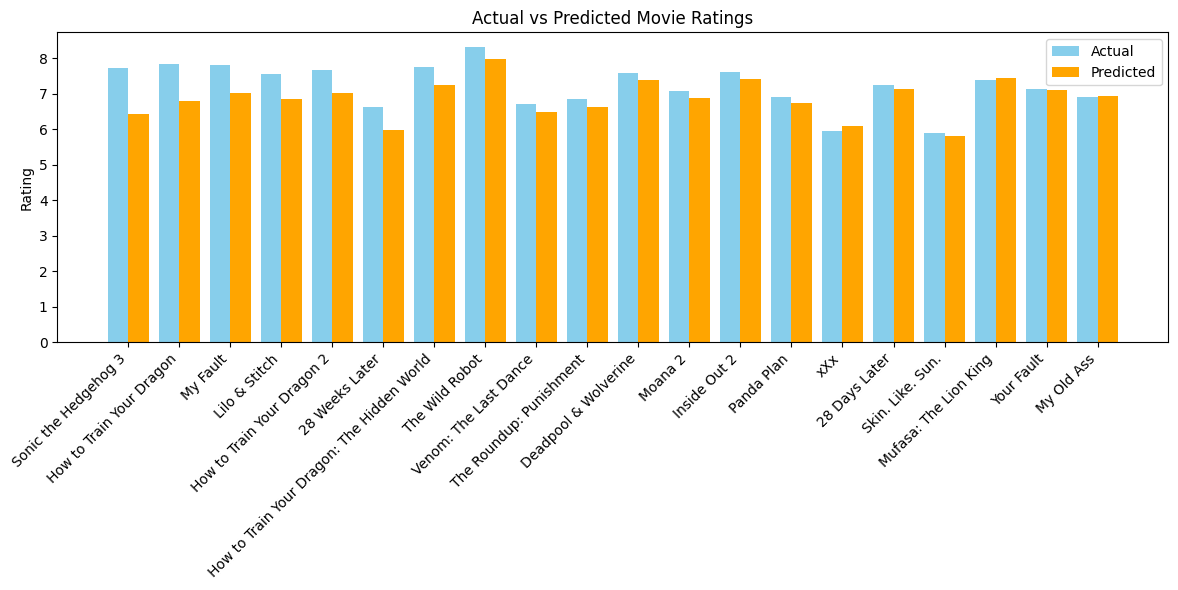

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot setup
plt.figure(figsize=(12, 6))
indices = np.arange(len(df_compare_sorted))

# Bar plot
plt.bar(indices - 0.2, df_compare_sorted['vote_average'], width=0.4, label='Actual', color='skyblue')
plt.bar(indices + 0.2, df_compare_sorted['predicted_rating'], width=0.4, label='Predicted', color='orange')

# Labels
plt.xticks(indices, df_compare_sorted['title'], rotation=45, ha='right')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Movie Ratings')
plt.legend()
plt.tight_layout()
plt.show()

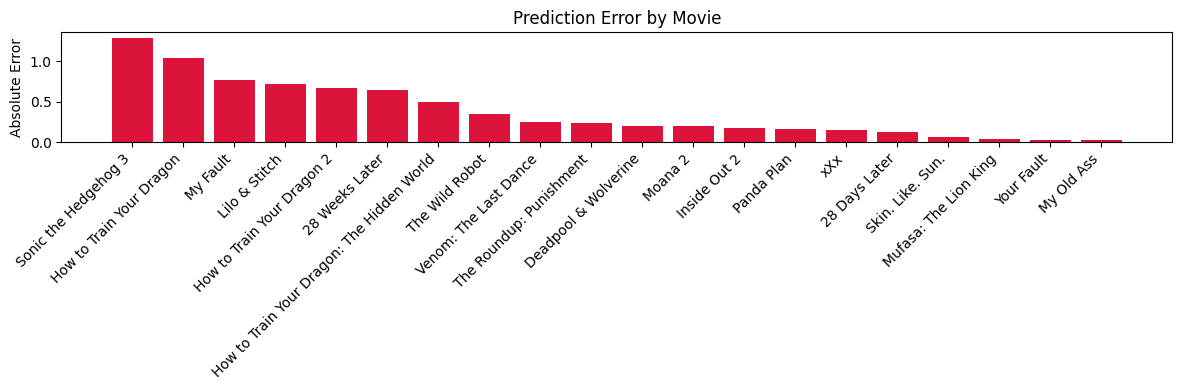

In [ ]:
plt.figure(figsize=(12, 4))
plt.bar(df_compare_sorted['title'], df_compare_sorted['error'], color='crimson')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Absolute Error')
plt.title('Prediction Error by Movie')
plt.tight_layout()
plt.show()

### Recomender

In [ ]:
df_10k_detailed['text'] = (
    df_10k_detailed['title'].fillna('') + ' ' +
    df_10k_detailed['overview'].fillna('')
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_10k_detailed['text'])

### Nearest Neighbor Model

In [ ]:
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

### Define Recommendation Function

In [ ]:
def recommend_similar_movies(title, k=5):
    idx = df_10k_detailed[df_10k_detailed['title'].str.lower() == title.lower()].index

    if len(idx) == 0:
        return "Movie title not found."

    idx = idx[0]
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=k+1)

    recommendations = df_10k_detailed.iloc[indices[0][1:]][['title', 'release_date', 'vote_average']]
    return recommendations

In [ ]:
recommend_similar_movies("The Matrix", k=5)

,title,release_date,vote_average
855,The Matrix Resurrections,2021-12-16,6.400
1936,Commando,1985-10-03,6.701
4779,The Animatrix,2003-05-09,7.192
753,The Matrix Reloaded,2003-05-15,7.058
2908,Hackers,1995-09-14,6.369


In [ ]:
# Get the missing columns (i.e., in full_feature_cols but not in df_june_structured)
missing_cols = [col for col in full_feature_cols if col not in df_june_structured.columns]

# Add them with default value 0
for col in missing_cols:
    df_june_structured[col] = 0